In [44]:
import wandb
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pyprojroot import here
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score, mean_squared_error
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score, classification_report
import optuna

In [45]:
#Loading datasets
raw_data = pd.read_csv(here('data/raw/ai4i2020.csv'))
X_train = pd.read_csv(here('data/processed/X_train_scaled.csv'))
print(X_train.shape)
y_train = pd.read_csv(here('data/processed/Y_train.csv'))
print(y_train.shape)


X_val = pd.read_csv(here('data/processed/X_val_scaled.csv'))
print(X_val.shape)
y_val = pd.read_csv(here('data/processed/Y_val.csv'))
print(y_val.shape)
print(y_train)
#Dropping Machine failure from targets
y_train = y_train.drop(labels=['Machine failure'],axis=1)
y_val = y_val.drop(labels=['Machine failure'], axis=1)

(7499, 6)
(7499, 6)
(1501, 6)
(1501, 6)
      Machine failure  TWF  HDF  PWF  OSF  RNF
0                   0    0    0    0    0    0
1                   0    0    0    0    0    0
2                   0    0    0    0    0    0
3                   0    0    0    0    0    0
4                   0    0    0    0    0    0
...               ...  ...  ...  ...  ...  ...
7494                0    0    0    0    0    0
7495                0    0    0    0    0    0
7496                0    0    0    0    0    0
7497                0    0    0    0    0    0
7498                0    0    0    0    0    0

[7499 rows x 6 columns]


Text(0.5, 1.0, 'X_train Scaled Data')

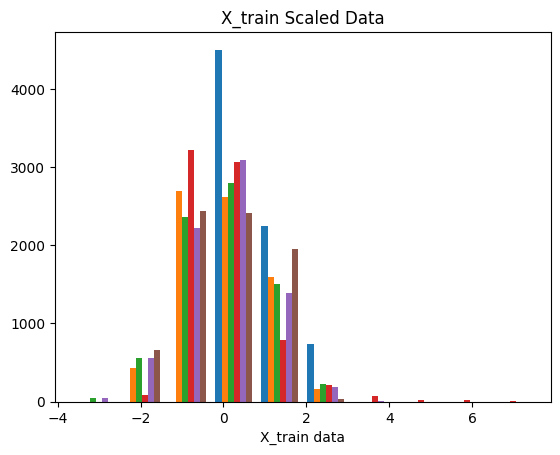

In [46]:
#Doing some exploration
#Making sure data is scaled on training data
plt.hist(X_train);
plt.xlabel('X_train data')
plt.title('X_train Scaled Data')



In [47]:
X_train.head()

,quality_variation,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
0,0,-0.998835,-1.149025,-0.359382,0.256796,-0.016174
1,0,0.247930,0.333286,-0.912986,0.738238,-0.817033
2,1,0.497283,0.468042,-0.248661,0.808448,0.580544
3,0,0.397542,0.468042,-0.425815,0.276856,1.020231
4,1,2.043272,2.152486,0.266191,0.106346,0.329294


In [48]:
raw_data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [49]:
base_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=3,
    max_features="sqrt",
    n_jobs=-1,
    random_state=7,
)
clf = OneVsRestClassifier(base_rf).fit(X_train, y_train)

In [50]:
class_names = y_train.columns
# probabilities
P_train = clf.predict_proba(X_train)
P_val   = clf.predict_proba(X_val)

# default threshold 0.5
y_val_hat = (P_val >= 0.5).astype(int)

# F1 and per-class report on VAL
print("F1 (micro):  ", f1_score(y_val, y_val_hat, average="micro"))
print("F1 (macro):  ", f1_score(y_val, y_val_hat, average="macro"))
print("F1 (samples):", f1_score(y_val, y_val_hat, average="samples"))
print(classification_report(y_val, y_val_hat, target_names=class_names, zero_division=0, digits=4))





F1 (micro):   0.5822784810126582
F1 (macro):   0.40242424242424246
F1 (samples): 0.014434821230290915
              precision    recall  f1-score   support

         TWF     0.0000    0.0000    0.0000         7
         HDF     1.0000    0.5000    0.6667        18
         PWF     0.8000    0.8000    0.8000        10
         OSF     1.0000    0.3750    0.5455        16
         RNF     0.0000    0.0000    0.0000         3

   micro avg     0.9200    0.4259    0.5823        54
   macro avg     0.5600    0.3350    0.4024        54
weighted avg     0.7778    0.4259    0.5320        54
 samples avg     0.0143    0.0147    0.0144        54



/Users/jubacochran/projects/student/207/w207-predictive-maintenance/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


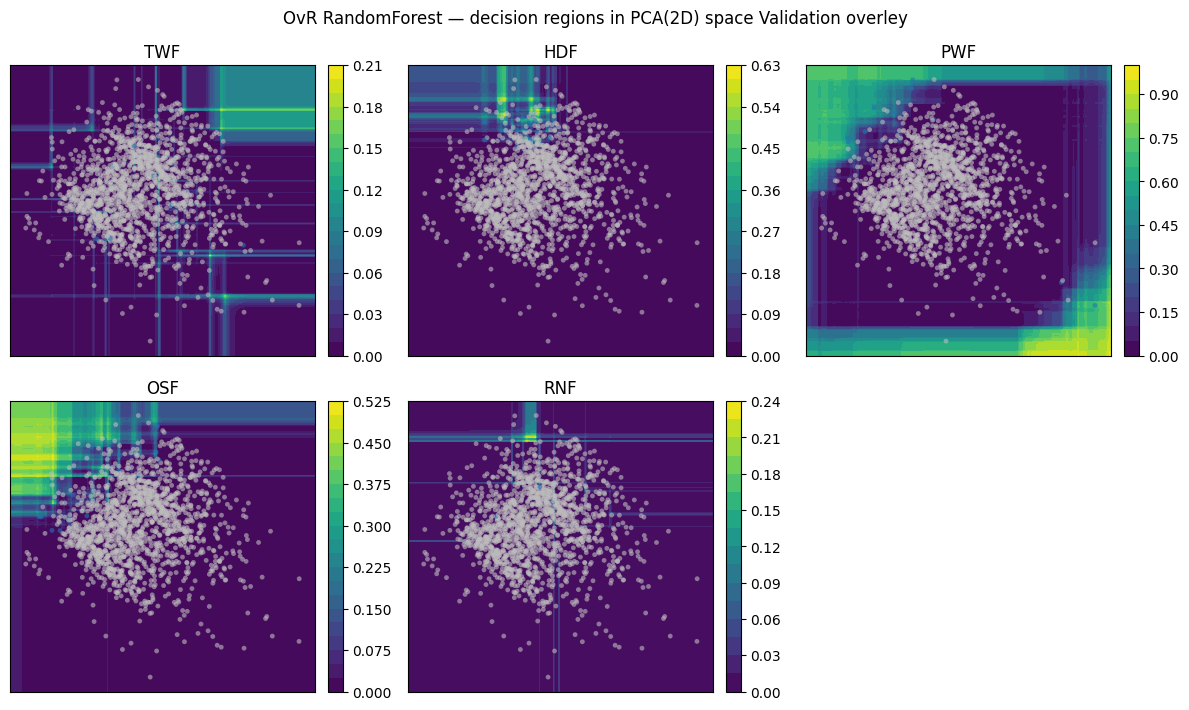

In [51]:
class_names = y_train.columns.tolist()
y_train_np  = y_train.to_numpy()
y_val_np    = y_val.to_numpy()
# PCA on TRAIN only
pca = PCA(n_components=2, random_state=7).fit(X_train)
Z_train = pca.transform(X_train)
Z_val   = pca.transform(X_val)

# OvR RF in PCA space
viz_clf = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=1000, max_features="sqrt", min_samples_leaf=3,
        n_jobs=-1, random_state=7
    )
).fit(Z_train, y_train_np)

# grid
x_min, x_max = Z_val[:, 0].min() - 0.5, Z_val[:, 0].max() + 0.5
y_min, y_max = Z_val[:, 1].min() - 0.5, Z_val[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

k = y_train_np.shape[1]
cols = 3
rows = int(np.ceil(k / cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 3.6*rows))
axes = np.atleast_1d(axes).ravel()

for j in range(k):
    ax = axes[j]
    Pj = viz_clf.estimators_[j].predict_proba(grid)[:, 1].reshape(xx.shape)
    cs = ax.contourf(xx, yy, Pj, levels=20)
    ax.scatter(Z_val[:, 0], Z_val[:, 1],
               c=y_val_np[:, j], s=12,
               cmap=ListedColormap(["#bdbdbd", "#1f77b4"]),
               alpha=0.6, edgecolor="none")
    ax.set_title(class_names[j])
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04)

for ax in axes[k:]:
    ax.axis("off")

fig.suptitle("OvR RandomForest — decision regions in PCA(2D) space Validation overley", y=0.98)
plt.tight_layout(); plt.show()

This plot shows the probability of failure is happening at the extermes of the plot. Mostly in the upper left section of the plot. In the middle probabilies of failure are almost non-existent except for TWF, this plot has some sections in the middle that are showing high probabilitiy of failure.